# Disease Progression Modeling with Continuous-Time MultiStateNN

This notebook demonstrates how to use continuous-time MultiStateNN to model disease progression through multiple states. We'll use synthetic data to model a disease that can progress through four states:

0. Healthy
1. Mild disease
2. Moderate disease
3. Severe disease (absorbing state)

We'll predict transition probabilities between these states based on patient characteristics using Neural ODEs for continuous-time modeling.

## Setup

First, let's import the necessary packages and set up our environment.

In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Import MultiStateNN package - updated for continuous-time models
from multistate_nn import (
    fit, ModelConfig, TrainConfig,
    # Import visualization methods
    plot_transition_heatmap,
    plot_transition_graph,
    plot_intensity_matrix
)

# Import utilities from the main package
from multistate_nn.utils.example_utils import (
    setup_state_names_and_colors,
    create_patient_profile,
    analyze_covariate_effect,
    visualize_state_distribution
)

# Import simulation utilities
from multistate_nn.utils.continuous_simulation import (
    simulate_continuous_patient_trajectory,
    simulate_continuous_cohort_trajectories
)

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

## Generate Synthetic Disease Progression Data

Let's create a synthetic dataset representing patient transitions between disease states over time.

In [2]:
# Define our state transition structure
# State 0: Healthy -> can progress to Mild (1) or Moderate (2)
# State 1: Mild -> can progress to Moderate (2) or Severe (3)
# State 2: Moderate -> can only progress to Severe (3) 
# State 3: Severe -> absorbing state (no further progression)
state_transitions = {
    0: [1, 2],    # From Healthy, can become Mild or Moderate
    1: [2, 3],    # From Mild, can become Moderate or Severe
    2: [3],       # From Moderate, can only become Severe
    3: []         # Severe is an absorbing state
}

In [3]:
# Generate synthetic data for continuous-time modeling
# We'll generate transitions with explicit start and end times
# Each person can progress through the disease states over time

def generate_continuous_synthetic_data(n_samples=1000, n_covariates=3, max_time=5.0):
    """Generate synthetic data for continuous-time multistate modeling."""
    
    # Define state transition structure
    state_transitions = {
        0: [1, 2],    # From Healthy, can become Mild or Moderate
        1: [2, 3],    # From Mild, can become Moderate or Severe
        2: [3],       # From Moderate, can only become Severe
        3: []         # Severe is an absorbing state
    }
    
    # Generate covariates
    covariates = np.random.randn(n_samples, n_covariates)
    
    # Generate disease progression data
    data = []
    for i in range(n_samples):
        patient_id = i
        current_state = 0  # Start in healthy state
        current_time = 0.0
        
        # Patient characteristics affect transition rates
        age_effect = covariates[i, 0]  # Higher age means faster progression
        biomarker_effect = covariates[i, 1]  # Higher biomarker means faster progression
        treatment_effect = covariates[i, 2]  # Higher treatment value means slower progression
        
        # Combined risk score (higher = faster disease progression)
        risk_score = age_effect + biomarker_effect - treatment_effect
        
        # Simulate disease progression until max_time
        while current_time < max_time and current_state < 3:
            # Determine time to next transition based on current state and risk
            # Higher risk = shorter time to transition
            base_rate = 0.5 / (current_state + 1)  # Base rate depends on current state
            rate_multiplier = np.exp(min(risk_score, 3))  # Exponential effect of risk, capped at e^3
            next_time = current_time + np.random.exponential(scale=base_rate / rate_multiplier)
            
            # If next transition happens after max_time, stop
            if next_time > max_time:
                break
                
            # Determine next state based on possible transitions
            possible_next_states = state_transitions[current_state]
            
            if len(possible_next_states) > 0:
                # Probability distribution depends on risk factors
                if len(possible_next_states) == 1:
                    # Only one possible next state
                    next_state = possible_next_states[0]
                else:
                    # Preferences for different transitions depend on covariates
                    # For example, higher biomarker might lead to skipping mild stage
                    if current_state == 0:  # From Healthy
                        # Higher biomarker increases chance of going directly to Moderate
                        p_mild = 1.0 / (1.0 + np.exp(biomarker_effect))  # Sigmoid transformation
                        next_state = np.random.choice([1, 2], p=[p_mild, 1-p_mild])
                    elif current_state == 1:  # From Mild
                        # Higher risk increases chance of going directly to Severe
                        p_moderate = 1.0 / (1.0 + np.exp(risk_score))  # Sigmoid transformation
                        next_state = np.random.choice([2, 3], p=[p_moderate, 1-p_moderate])
                    else:
                        # Default behavior: uniform choice among possible next states
                        next_state = np.random.choice(possible_next_states)
                
                # Record the transition
                data.append({
                    'patient_id': patient_id,
                    'time_start': current_time,
                    'time_end': next_time,
                    'from_state': current_state,
                    'to_state': next_state,
                    'age': covariates[i, 0],
                    'biomarker': covariates[i, 1],
                    'treatment': covariates[i, 2]
                })
                
                # Update current state and time
                current_state = next_state
                current_time = next_time
            else:
                # No further transitions possible (absorbing state)
                break
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    
    # Make treatment binary (for interpretability)
    df['treatment'] = (df['treatment'] > 0).astype(int)
    
    # Rescale age to be more realistic (mean 65, std 10)
    df['age'] = 65 + 10 * df['age']
    
    return df

# Generate the data
df = generate_continuous_synthetic_data(n_samples=1000, n_covariates=3, max_time=5.0)
df.head()

,patient_id,time_start,time_end,from_state,to_state,age,biomarker,treatment
0,0,0.000000,1.140323,0,2,69.967142,-0.138264,1
1,0,1.140323,1.207241,2,3,69.967142,-0.138264,1
2,1,0.000000,0.381309,0,1,80.230299,-0.234153,0
3,1,0.381309,0.404585,1,2,80.230299,-0.234153,0
4,1,0.404585,0.406555,2,3,80.230299,-0.234153,0


## Explore the Dataset

Let's examine the distribution of the covariates and transitions in our dataset.

/Users/denizakdemir/.pyenv/versions/3.10.0/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/denizakdemir/.pyenv/versions/3.10.0/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


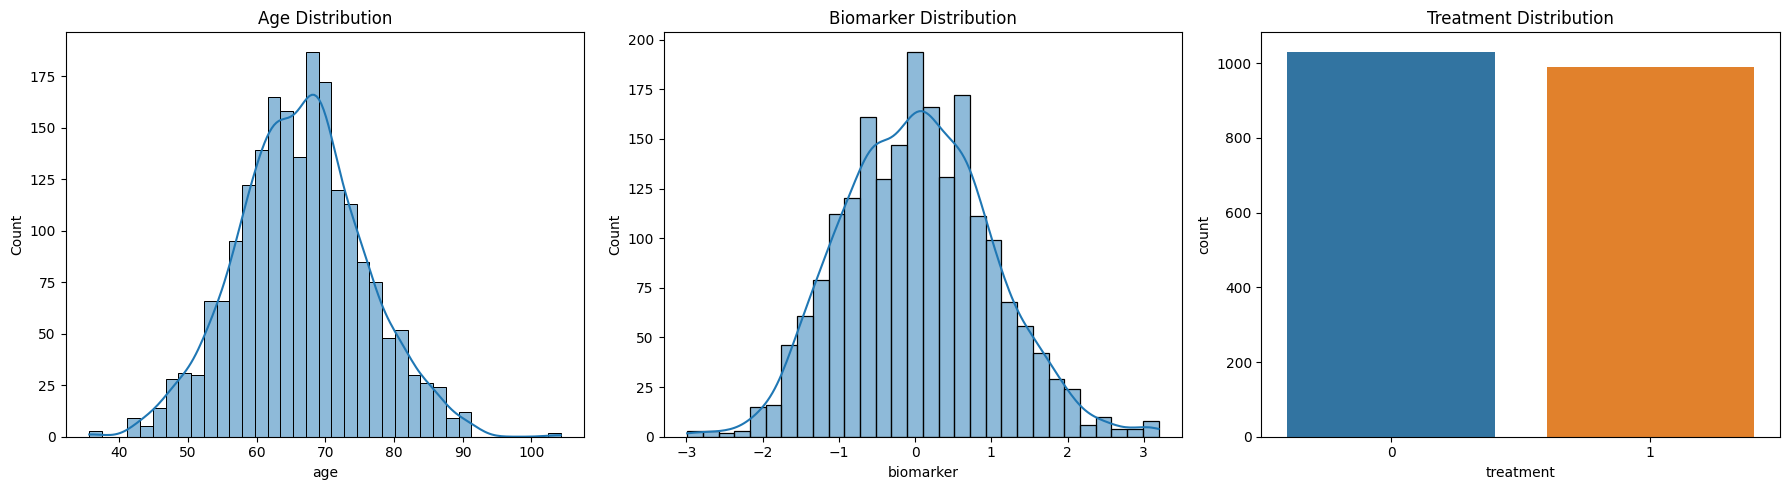

In [4]:
# Visualize covariate distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(df['age'], kde=True, ax=axes[0])
axes[0].set_title('Age Distribution')

sns.histplot(df['biomarker'], kde=True, ax=axes[1])
axes[1].set_title('Biomarker Distribution')

sns.countplot(x='treatment', data=df, ax=axes[2])
axes[2].set_title('Treatment Distribution')

plt.tight_layout()
plt.show()

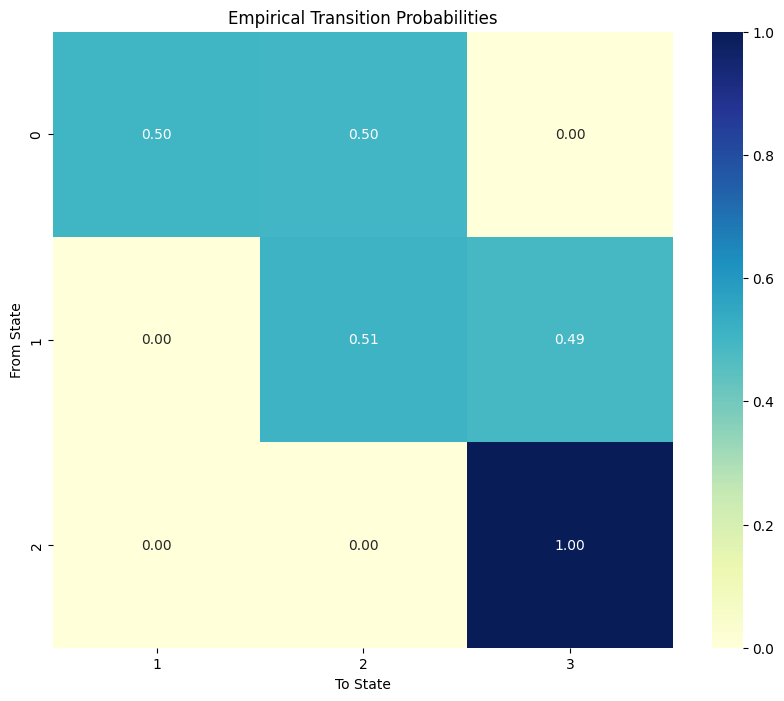

In [5]:
# Examine transition patterns
transition_counts = df.groupby(['from_state', 'to_state']).size().unstack(fill_value=0)
transition_prob = transition_counts.div(transition_counts.sum(axis=1), axis=0)

plt.figure(figsize=(10, 8))
sns.heatmap(transition_prob, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Empirical Transition Probabilities')
plt.xlabel('To State')
plt.ylabel('From State')
plt.show()

In [6]:
# Define our state transition structure
# State 0: Healthy -> can progress to Mild (1) or Moderate (2)
# State 1: Mild -> can progress to Moderate (2) or Severe (3)
# State 2: Moderate -> can only progress to Severe (3) 
# State 3: Severe -> absorbing state (no further progression)
state_transitions = {
    0: [1, 2],    # From Healthy, can become Mild or Moderate
    1: [2, 3],    # From Mild, can become Moderate or Severe
    2: [3],       # From Moderate, can only become Severe
    3: []         # Severe is an absorbing state
}

# Define our covariates
feature_names = ['age', 'biomarker', 'treatment']
input_dim = len(feature_names)

# Define model architecture
hidden_dims = [64, 32]  # Two hidden layers
num_states = 4

# Create configuration objects for the model and training
model_config = ModelConfig(
    input_dim=input_dim,
    hidden_dims=hidden_dims,
    num_states=num_states,
    state_transitions=state_transitions,
    model_type="continuous"  # Specify continuous-time model
)

# Note: rtol and atol should NOT be in both options and parameters to avoid duplication
train_config = TrainConfig(
    epochs=5,
    batch_size=64,
    learning_rate=0.001,
    ode_solver="dopri5",  # ODE solver method
    # Don't include rtol/atol in solver_options as they are passed separately
    ode_solver_options={"step_size": 0.05}  # Only include other options here
)

In [7]:
# Fit the model using the configuration-based API
# Note the time_start_col and time_end_col parameters for continuous-time modeling
model = fit(
    df=df,
    covariates=feature_names,
    model_config=model_config,
    train_config=train_config,
    time_start_col='time_start',  # Specify column containing start times
    time_end_col='time_end'       # Specify column containing end times
)

print("Model training complete!")

Training continuous-time model:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/denizakdemir/.pyenv/versions/3.10.0/lib/python3.10/site-packages/torchdiffeq/_impl/misc.py:15: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 0.05}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


Model training complete!


In [8]:
# Display model summary (we'll visualize the transition graph later after defining x_test)
try:
    # Get model summary
    summary_info = model.summary()
    print("Model Summary:")
    print(summary_info)
    
    # Display a table of model parameters
    print("\nModel Parameters:")
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{name} - Shape: {param.shape}")
    
    # We'll visualize the model's transition structure later after defining x_test
except Exception as e:
    print(f"Error displaying model summary: {str(e)}")
    print("This feature may require an updated version of the multistate_nn package.")

==== ContinuousMultiStateNN Summary ====
Input dimension: 3
Number of states: 4
State transition structure:
  State 0 → States [1, 2]
  State 1 → States [2, 3]
  State 2 → States [3]
  State 3 (absorbing state)
Group structure present: No
Total parameters: 3,056
Trainable parameters: 3,056

Continuous-time model specific:
ODE solver: dopri5
Solver options:
  step_size: 0.05

Network architecture:
Feature extraction: Linear(3, 64) -> ReLU() -> LayerNorm(64) -> Linear(64, 32) -> ReLU() -> LayerNorm(32)
Intensity network: Linear(32, 16)
Model Summary:
{'model_type': 'ContinuousMultiStateNN', 'input_dim': 3, 'num_states': 4, 'state_transitions': {0: [1, 2], 1: [2, 3], 2: [3], 3: []}, 'has_group_structure': False, 'total_params': 3056, 'trainable_params': 3056, 'ode_solver': 'dopri5', 'ode_solver_options': {'step_size': 0.05}, 'hidden_dims': 32, 'architecture': {'feature_extraction': ['Linear(3, 64)', 'ReLU()', 'LayerNorm(64)', 'Linear(64, 32)', 'ReLU()', 'LayerNorm(32)'], 'intensity_networ

In [9]:
# Function to print predicted probabilities with labels
def print_transition_probs(x, model, time_interval, from_state):
    """Print transition probabilities for a given time interval."""
    time_start, time_end = time_interval
    probs = model.predict_proba(x, time_start=time_start, time_end=time_end, from_state=from_state).detach().numpy()
    
    # Get the possible next states
    next_states = model.state_transitions[from_state]
    
    # Map state indices to names
    state_names = ['Healthy', 'Mild', 'Moderate', 'Severe']
    state_from = state_names[from_state]
    next_state_names = [state_names[s] for s in next_states]
    
    # Create labels for the profiles
    profiles = [
        f"Age: {x[i,0]:.0f}, Biomarker: {x[i,1]:.1f}, Treatment: {int(x[i,2])}"
        for i in range(len(x))
    ]
    
    # Extract only columns for valid next states
    filtered_probs = probs[:, next_states]
    
    # Create DataFrame for display
    result_df = pd.DataFrame(filtered_probs, index=profiles, columns=next_state_names)
    print(f"Transition probabilities from {state_from} state (t={time_start} to t={time_end}):")
    return result_df

# Create test profiles
x_test = torch.tensor([
    [70, 1.5, 0],  # Older, high biomarker, no treatment (higher risk)
    [70, 1.5, 1],  # Older, high biomarker, with treatment
    [50, 1.5, 0],  # Younger, high biomarker, no treatment
    [50, 1.5, 1],  # Younger, high biomarker, with treatment
    [70, 0.5, 0],  # Older, low biomarker, no treatment
    [70, 0.5, 1],  # Older, low biomarker, with treatment
    [50, 0.5, 0],  # Younger, low biomarker, no treatment
    [50, 0.5, 1],  # Younger, low biomarker, with treatment (lower risk)
], dtype=torch.float32)

<Figure size 1000x800 with 0 Axes>

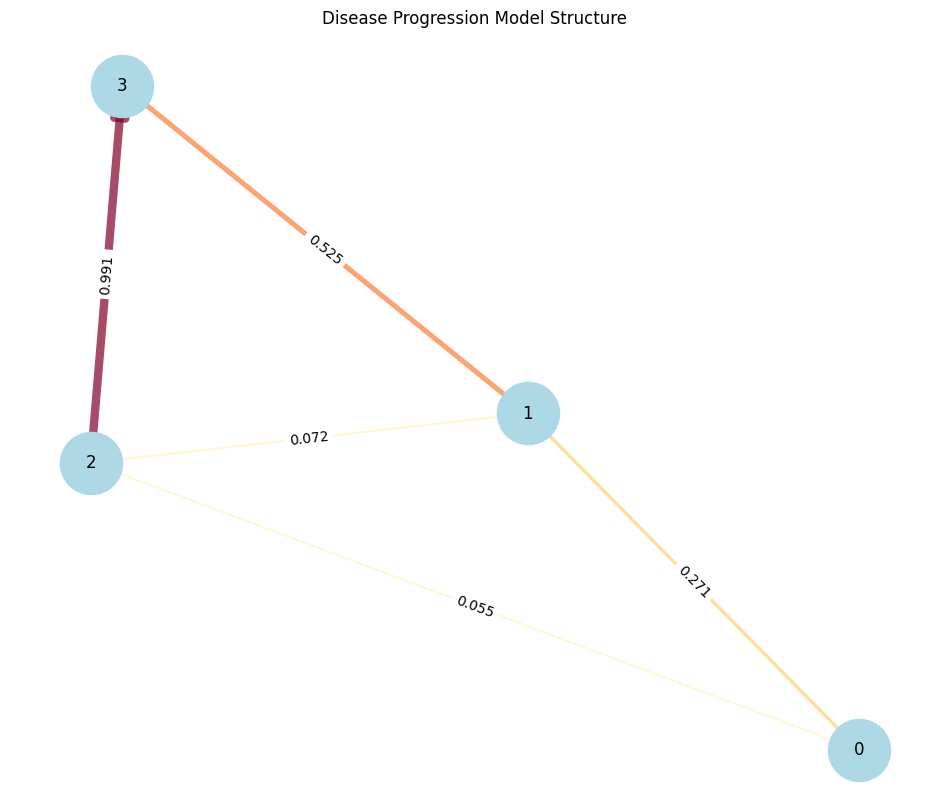

In [10]:
# Now that we have x_test defined, let's visualize the model's transition structure
try:
    plt.figure(figsize=(10, 8))
    # Use a sample input for visualization
    sample_input = x_test[0:1]  # Using the first patient profile
    
    # Create explicit tensors with proper dtype to avoid type mismatches
    time_start = torch.tensor([0.0], dtype=torch.float32)
    time_end = torch.tensor([1.0], dtype=torch.float32)
    
    # Use the plotting function from the library
    # Note: plot_transition_graph doesn't accept a show_labels parameter
    ax = plot_transition_graph(model, sample_input, 
                              time_start=time_start, time_end=time_end, 
                              threshold=0.01)
    plt.title("Disease Progression Model Structure")
    plt.show()
except Exception as e:
    print(f"Error displaying transition graph: {str(e)}")
    print("This issue might be related to the visualization function implementation.")

In [11]:
# Predict transitions from Healthy (State 0) over a 1-year interval
healthy_probs = print_transition_probs(x_test, model, time_interval=(0.0, 1.0), from_state=0)
healthy_probs

Transition probabilities from Healthy state (t=0.0 to t=1.0):


,Mild,Moderate
"Age: 70, Biomarker: 1.5, Treatment: 0",0.271287,0.054623
"Age: 70, Biomarker: 1.5, Treatment: 1",0.272786,0.054707
"Age: 50, Biomarker: 1.5, Treatment: 0",0.268657,0.054643
"Age: 50, Biomarker: 1.5, Treatment: 1",0.270745,0.054764
"Age: 70, Biomarker: 0.5, Treatment: 0",0.275956,0.054671
"Age: 70, Biomarker: 0.5, Treatment: 1",0.277474,0.054757
"Age: 50, Biomarker: 0.5, Treatment: 0",0.275205,0.054696
"Age: 50, Biomarker: 0.5, Treatment: 1",0.277331,0.054821


In [12]:
# Predict transitions from Mild (State 1) over a 1-year interval
mild_probs = print_transition_probs(x_test, model, time_interval=(0.0, 1.0), from_state=1)
mild_probs

Transition probabilities from Mild state (t=0.0 to t=1.0):


/Users/denizakdemir/.pyenv/versions/3.10.0/lib/python3.10/site-packages/torchdiffeq/_impl/misc.py:15: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 0.05}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


,Moderate,Severe
"Age: 70, Biomarker: 1.5, Treatment: 0",0.071715,0.525197
"Age: 70, Biomarker: 1.5, Treatment: 1",0.071701,0.523612
"Age: 50, Biomarker: 1.5, Treatment: 0",0.071908,0.528259
"Age: 50, Biomarker: 1.5, Treatment: 1",0.071894,0.526046
"Age: 70, Biomarker: 0.5, Treatment: 0",0.071521,0.519283
"Age: 70, Biomarker: 0.5, Treatment: 1",0.071507,0.517691
"Age: 50, Biomarker: 0.5, Treatment: 0",0.071628,0.519940
"Age: 50, Biomarker: 0.5, Treatment: 1",0.071612,0.517709


/var/folders/7z/7gnwr49s6hl4pp9j5dcmgns80000gn/T/ipykernel_94091/3919968685.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 2)
/var/folders/7z/7gnwr49s6hl4pp9j5dcmgns80000gn/T/ipykernel_94091/3919968685.py:26: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 3)
/var/folders/7z/7gnwr49s6hl4pp9j5dcmgns80000gn/T/ipykernel_94091/3919968685.py:32: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 4)


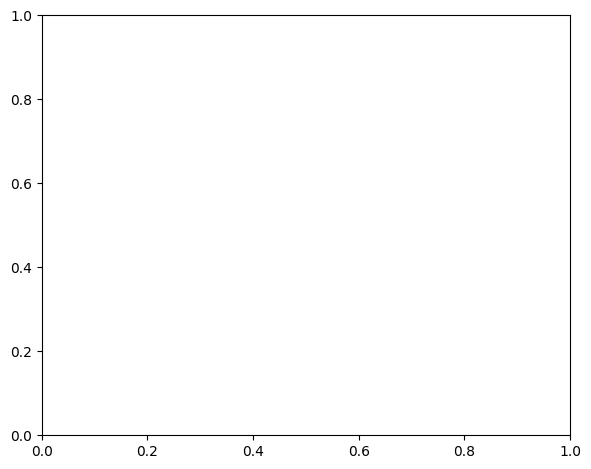

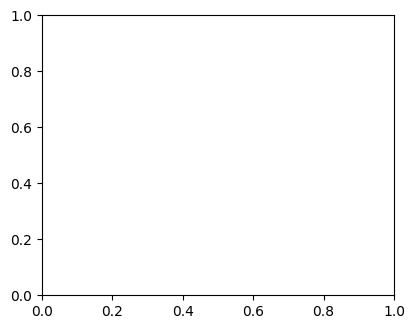

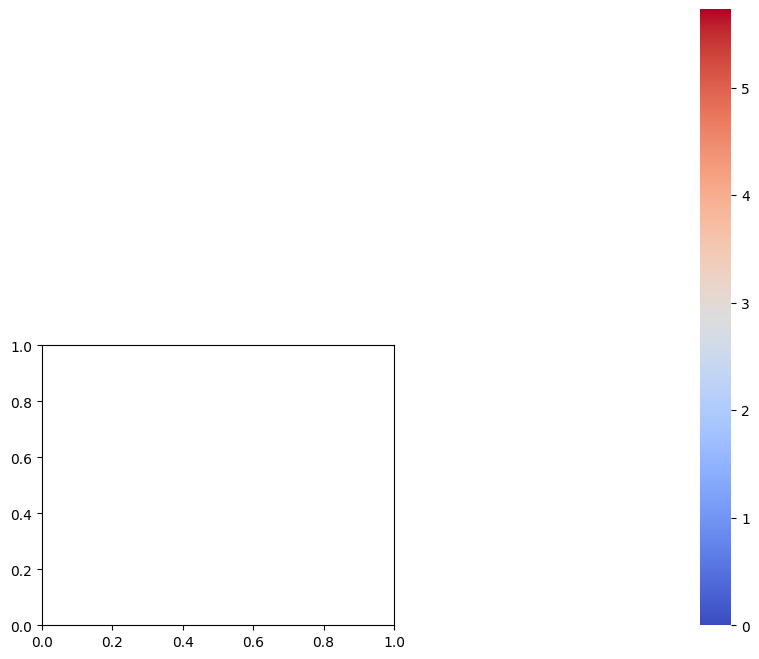

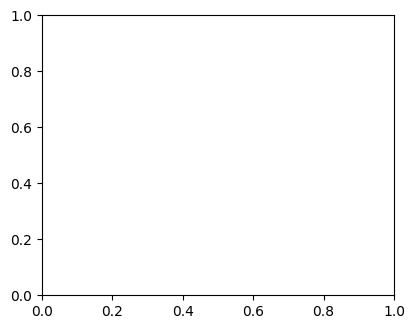

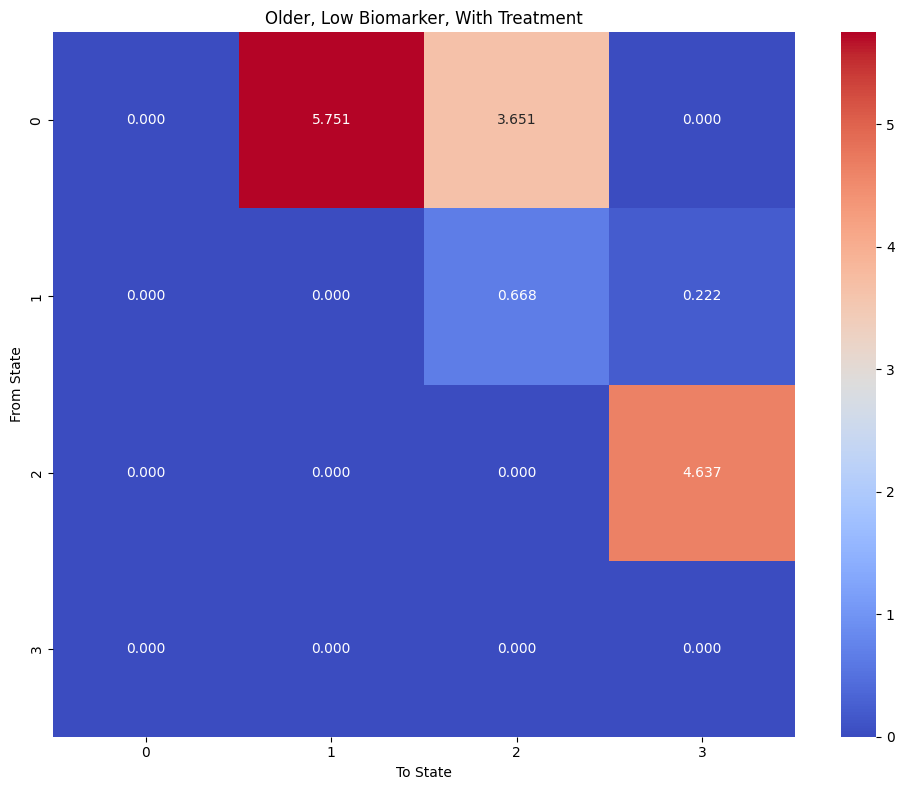

In [13]:
# Define state names and colors for better visualization
state_names = ['Healthy', 'Mild', 'Moderate', 'Severe']
state_colors = ['green', 'orange', 'red', 'darkred']

# Use the utility function to set up state names and colors
# First parameter should be the number of states, not the state_names list
num_states = len(state_names)
state_name_dict, state_color_dict = setup_state_names_and_colors(num_states, state_names, state_colors)

# Visualize the intensity matrix for different patient profiles
plt.figure(figsize=(15, 12))

# Low-risk patient: Young, low biomarker, with treatment
plt.subplot(2, 2, 1)
patient_profile = x_test[7:8]  # Young, Low Biomarker, With Treatment
ax = plot_intensity_matrix(model, patient_profile)
plt.title("Young, Low Biomarker, With Treatment")

# High-risk patient: Older, high biomarker, no treatment  
plt.subplot(2, 2, 2)
patient_profile = x_test[0:1]  # Older, High Biomarker, No Treatment
ax = plot_intensity_matrix(model, patient_profile)
plt.title("Older, High Biomarker, No Treatment")

# Medium-risk patient 1: Young, high biomarker, no treatment
plt.subplot(2, 2, 3)
patient_profile = x_test[2:3]  # Young, High Biomarker, No Treatment
ax = plot_intensity_matrix(model, patient_profile)
plt.title("Young, High Biomarker, No Treatment")

# Medium-risk patient 2: Older, low biomarker, with treatment
plt.subplot(2, 2, 4)
patient_profile = x_test[5:6]  # Older, Low Biomarker, With Treatment
ax = plot_intensity_matrix(model, patient_profile)
plt.title("Older, Low Biomarker, With Treatment")

plt.tight_layout()
plt.show()

/var/folders/7z/7gnwr49s6hl4pp9j5dcmgns80000gn/T/ipykernel_94091/3919968685.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 2)
/var/folders/7z/7gnwr49s6hl4pp9j5dcmgns80000gn/T/ipykernel_94091/3919968685.py:26: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 3)
/var/folders/7z/7gnwr49s6hl4pp9j5dcmgns80000gn/T/ipykernel_94091/3919968685.py:32: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 4)


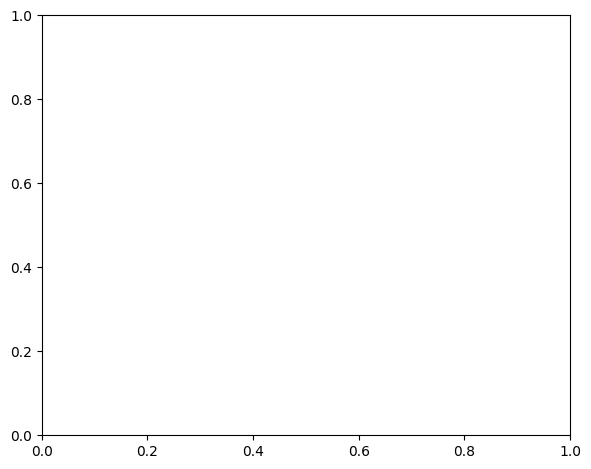

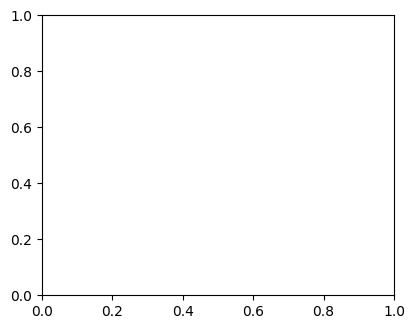

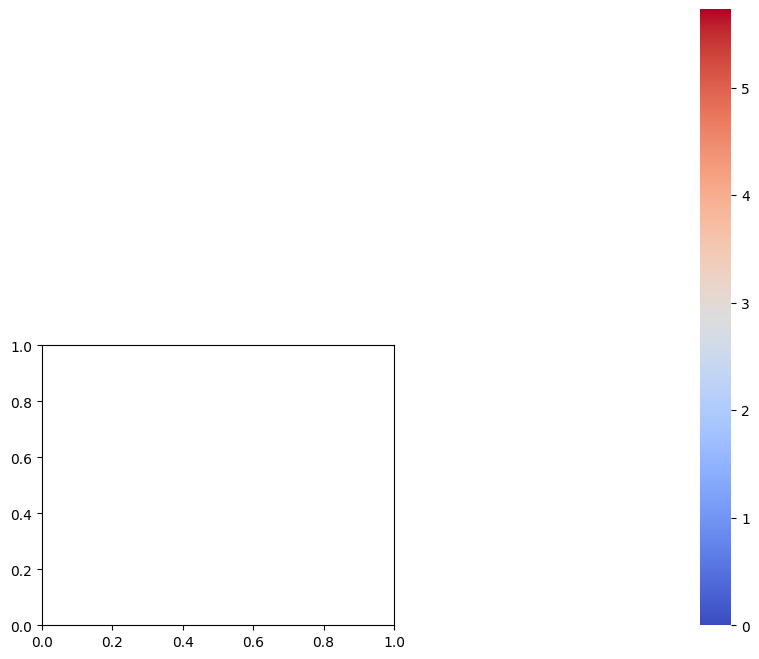

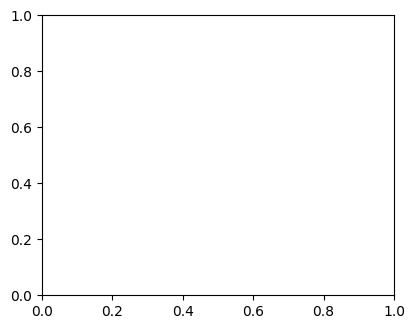

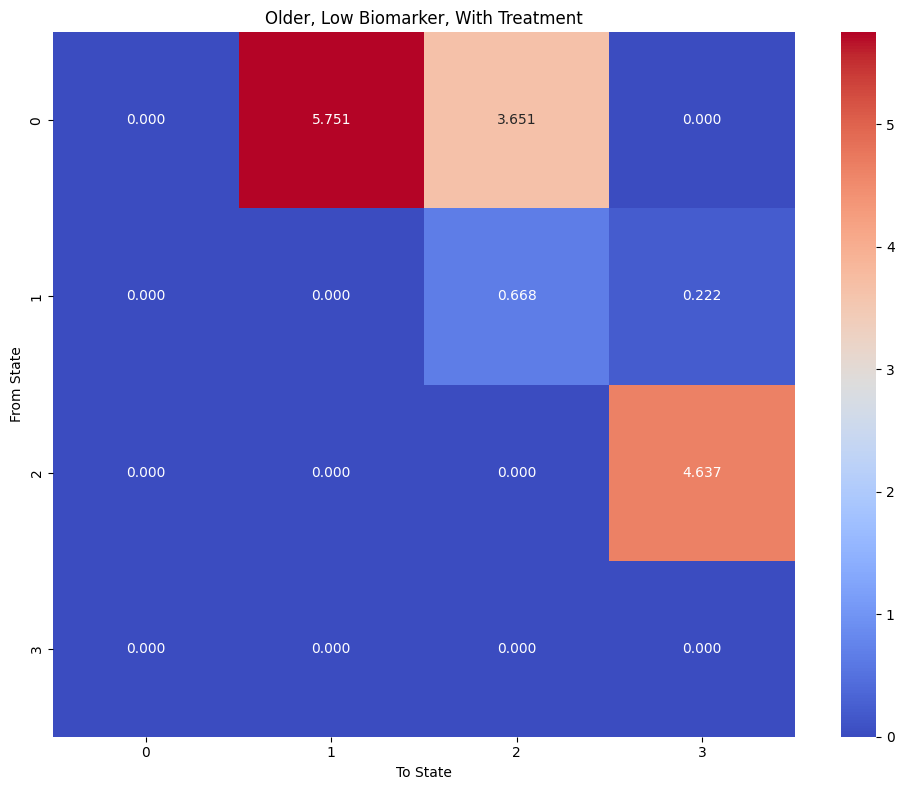

In [14]:
# Define state names and colors for better visualization
state_names = ['Healthy', 'Mild', 'Moderate', 'Severe']
state_colors = ['green', 'orange', 'red', 'darkred']

# Use the utility function to set up state names and colors
# First parameter should be the number of states, not the state_names list
num_states = len(state_names)
state_name_dict, state_color_dict = setup_state_names_and_colors(num_states, state_names, state_colors)

# Visualize the intensity matrix for different patient profiles
plt.figure(figsize=(15, 12))

# Low-risk patient: Young, low biomarker, with treatment
plt.subplot(2, 2, 1)
patient_profile = x_test[7:8]  # Young, Low Biomarker, With Treatment
ax = plot_intensity_matrix(model, patient_profile)
plt.title("Young, Low Biomarker, With Treatment")

# High-risk patient: Older, high biomarker, no treatment  
plt.subplot(2, 2, 2)
patient_profile = x_test[0:1]  # Older, High Biomarker, No Treatment
ax = plot_intensity_matrix(model, patient_profile)
plt.title("Older, High Biomarker, No Treatment")

# Medium-risk patient 1: Young, high biomarker, no treatment
plt.subplot(2, 2, 3)
patient_profile = x_test[2:3]  # Young, High Biomarker, No Treatment
ax = plot_intensity_matrix(model, patient_profile)
plt.title("Young, High Biomarker, No Treatment")

# Medium-risk patient 2: Older, low biomarker, with treatment
plt.subplot(2, 2, 4)
patient_profile = x_test[5:6]  # Older, Low Biomarker, With Treatment
ax = plot_intensity_matrix(model, patient_profile)
plt.title("Older, Low Biomarker, With Treatment")

plt.tight_layout()
plt.show()

/Users/denizakdemir/.pyenv/versions/3.10.0/lib/python3.10/site-packages/torchdiffeq/_impl/misc.py:15: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 0.05}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
/var/folders/7z/7gnwr49s6hl4pp9j5dcmgns80000gn/T/ipykernel_94091/4208926400.py:52: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 2)
/var/folders/7z/7gnwr49s6hl4pp9j5dcmgns80000gn/T/ipykernel_94091/4208926400.py:57: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 3)
/var/folders/7z/7gnwr49s6hl4pp9j5dcmgns80000gn/T/ipykernel_94091/4208926400.py:62: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will

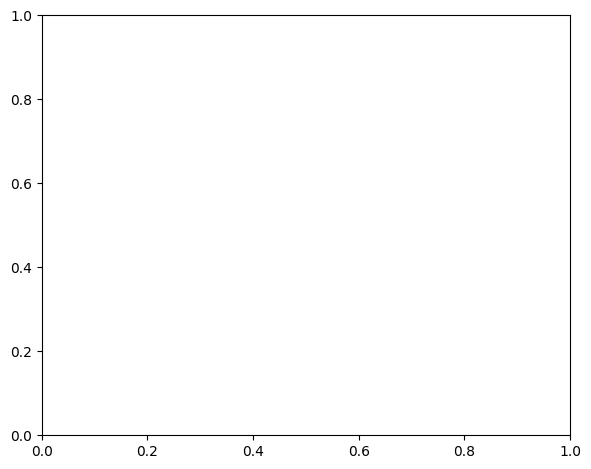

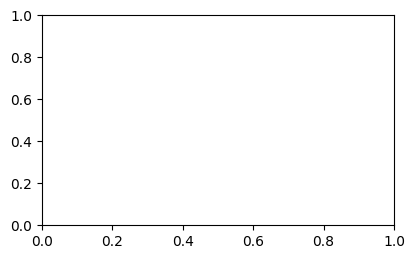

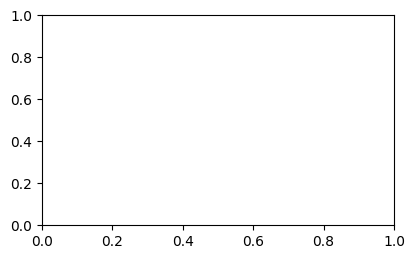

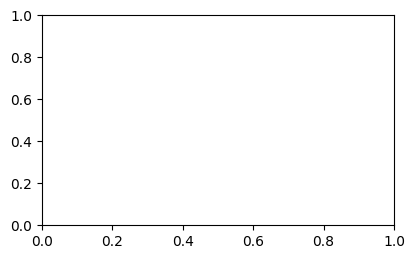

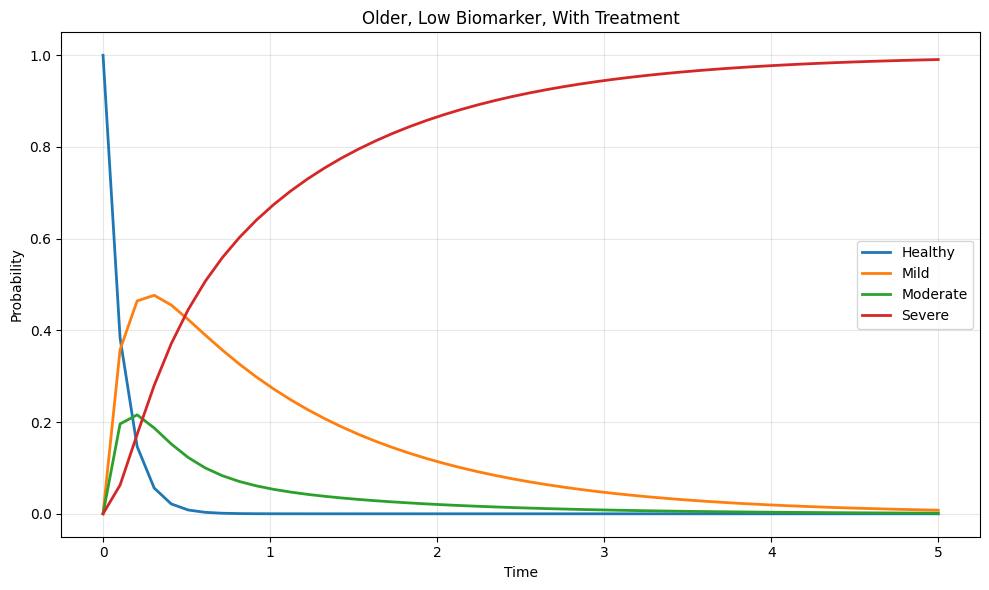

In [15]:
# Visualize transition probabilities over time
def plot_transition_probabilities_over_time(model, x, from_state=0, max_time=5.0, num_points=50, patient_idx=0):
    """Plot transition probabilities over time for a patient."""
    # Create time grid
    times = np.linspace(0, max_time, num_points)
    
    # Get patient feature
    single_x = x[patient_idx:patient_idx+1]
    
    # Initialize arrays for probabilities
    state_names = ['Healthy', 'Mild', 'Moderate', 'Severe']
    probs = np.zeros((num_points, len(state_names)))
    
    # Create tensor for time_start with proper dtype
    time_start = torch.tensor([0.0], dtype=torch.float32)
    
    # Calculate probabilities at each time point
    for i, t in enumerate(times):
        if i == 0:
            # At t=0, probability of being in the initial state is 1
            probs[i, from_state] = 1.0
        else:
            # Get probabilities from model
            # Convert time to tensor with proper dtype
            time_end = torch.tensor([float(t)], dtype=torch.float32)
            p = model.predict_proba(single_x, time_start=time_start, time_end=time_end, from_state=from_state).detach()
            probs[i] = p.squeeze().numpy()
    
    # Plot the probabilities
    plt.figure(figsize=(10, 6))
    for j in range(len(state_names)):
        plt.plot(times, probs[:, j], label=f"{state_names[j]}", linewidth=2)
    
    # Add patient info to title
    patient_info = f"Age: {x[patient_idx,0]:.0f}, Biomarker: {x[patient_idx,1]:.1f}, Treatment: {int(x[patient_idx,2])}"
    plt.title(f"Transition Probabilities from {state_names[from_state]} - {patient_info}")
    plt.xlabel("Time")
    plt.ylabel("Probability")
    plt.legend()
    plt.grid(alpha=0.3)
    return plt.gca()

# Plot transition probabilities over time for different patient profiles
plt.figure(figsize=(15, 12))

# Low-risk patient: Young, low biomarker, with treatment
plt.subplot(2, 2, 1)
plot_transition_probabilities_over_time(model, x_test, from_state=0, patient_idx=7)
plt.title("Young, Low Biomarker, With Treatment")

# High-risk patient: Older, high biomarker, no treatment
plt.subplot(2, 2, 2)
plot_transition_probabilities_over_time(model, x_test, from_state=0, patient_idx=0)
plt.title("Older, High Biomarker, No Treatment")

# Medium-risk patient 1: Young, high biomarker, no treatment
plt.subplot(2, 2, 3)
plot_transition_probabilities_over_time(model, x_test, from_state=0, patient_idx=2)
plt.title("Young, High Biomarker, No Treatment")

# Medium-risk patient 2: Older, low biomarker, with treatment
plt.subplot(2, 2, 4)
plot_transition_probabilities_over_time(model, x_test, from_state=0, patient_idx=5)
plt.title("Older, Low Biomarker, With Treatment")

plt.tight_layout()
plt.show()

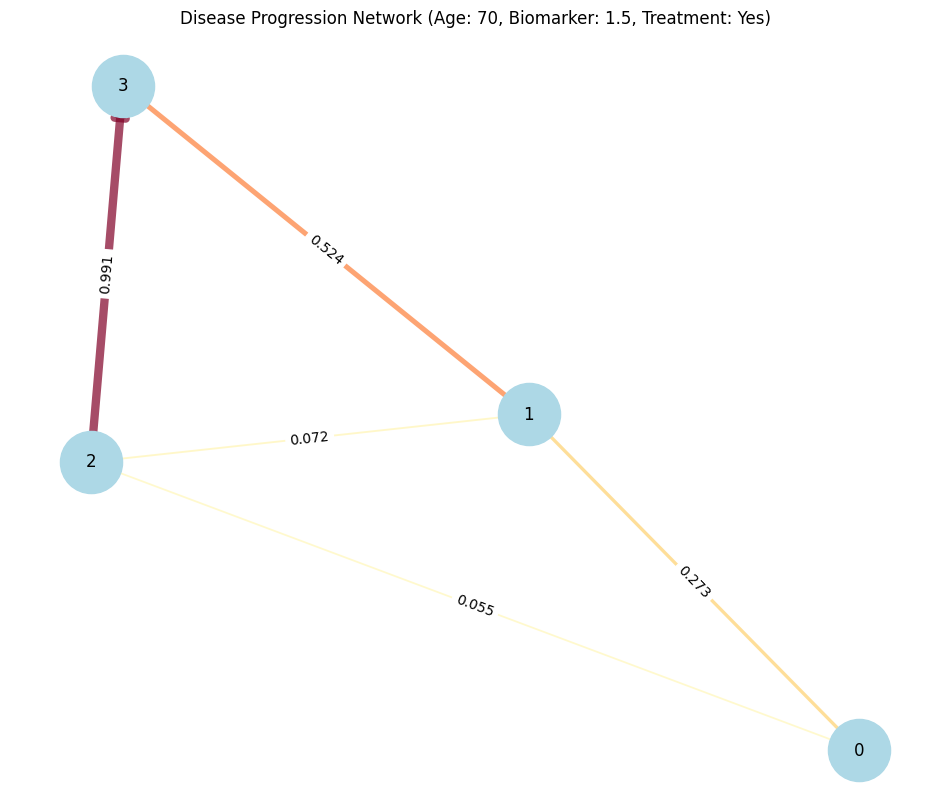

In [16]:
# Import visualization tools from multistate_nn.utils
from multistate_nn.utils import plot_transition_graph

# Visualize the transition graph for a specific patient
# Let's use an older patient with high biomarker and treatment
patient1 = torch.tensor([[70, 1.5, 1]], dtype=torch.float32)

# Use explicit time tensors with float32 type to avoid float/double mismatch
time_start = torch.tensor([0.0], dtype=torch.float32)
time_end = torch.tensor([1.0], dtype=torch.float32)

# Plot the transition graph
try:
    fig, ax = plot_transition_graph(model, patient1, time_start=time_start, time_end=time_end, threshold=0.01)
    plt.title("Disease Progression Network (Age: 70, Biomarker: 1.5, Treatment: Yes)")
    plt.show()
except Exception as e:
    print(f"Error plotting transition graph: {str(e)}")
    print("This might be due to a data type mismatch in the time values.")

/var/folders/7z/7gnwr49s6hl4pp9j5dcmgns80000gn/T/ipykernel_94091/3768570728.py:20: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


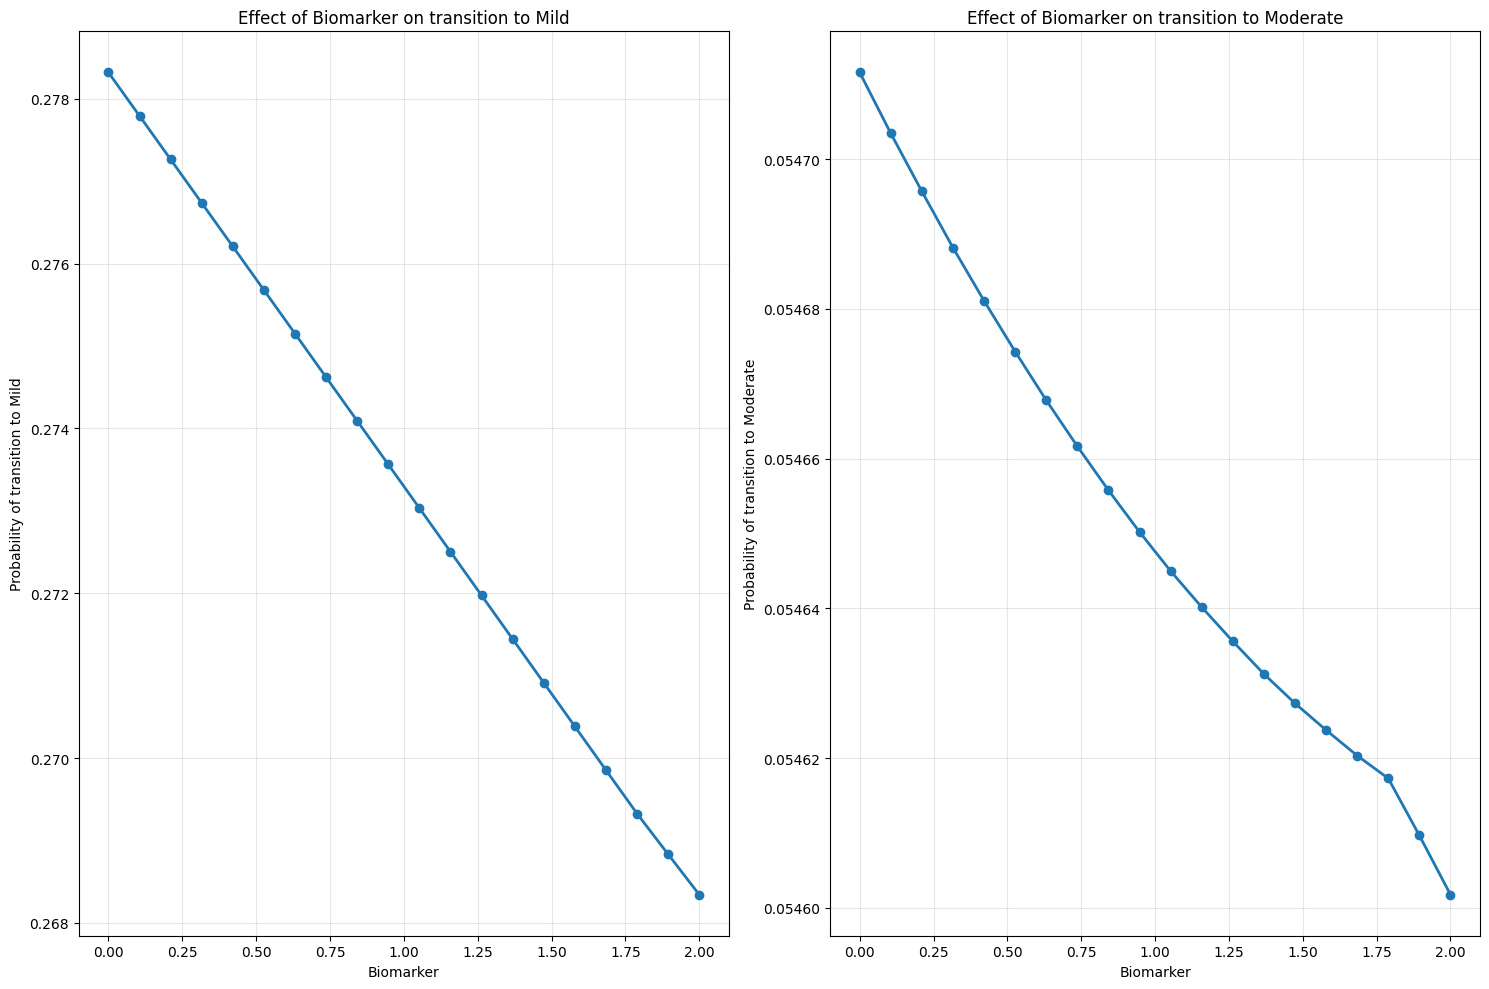

/var/folders/7z/7gnwr49s6hl4pp9j5dcmgns80000gn/T/ipykernel_94091/3768570728.py:35: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


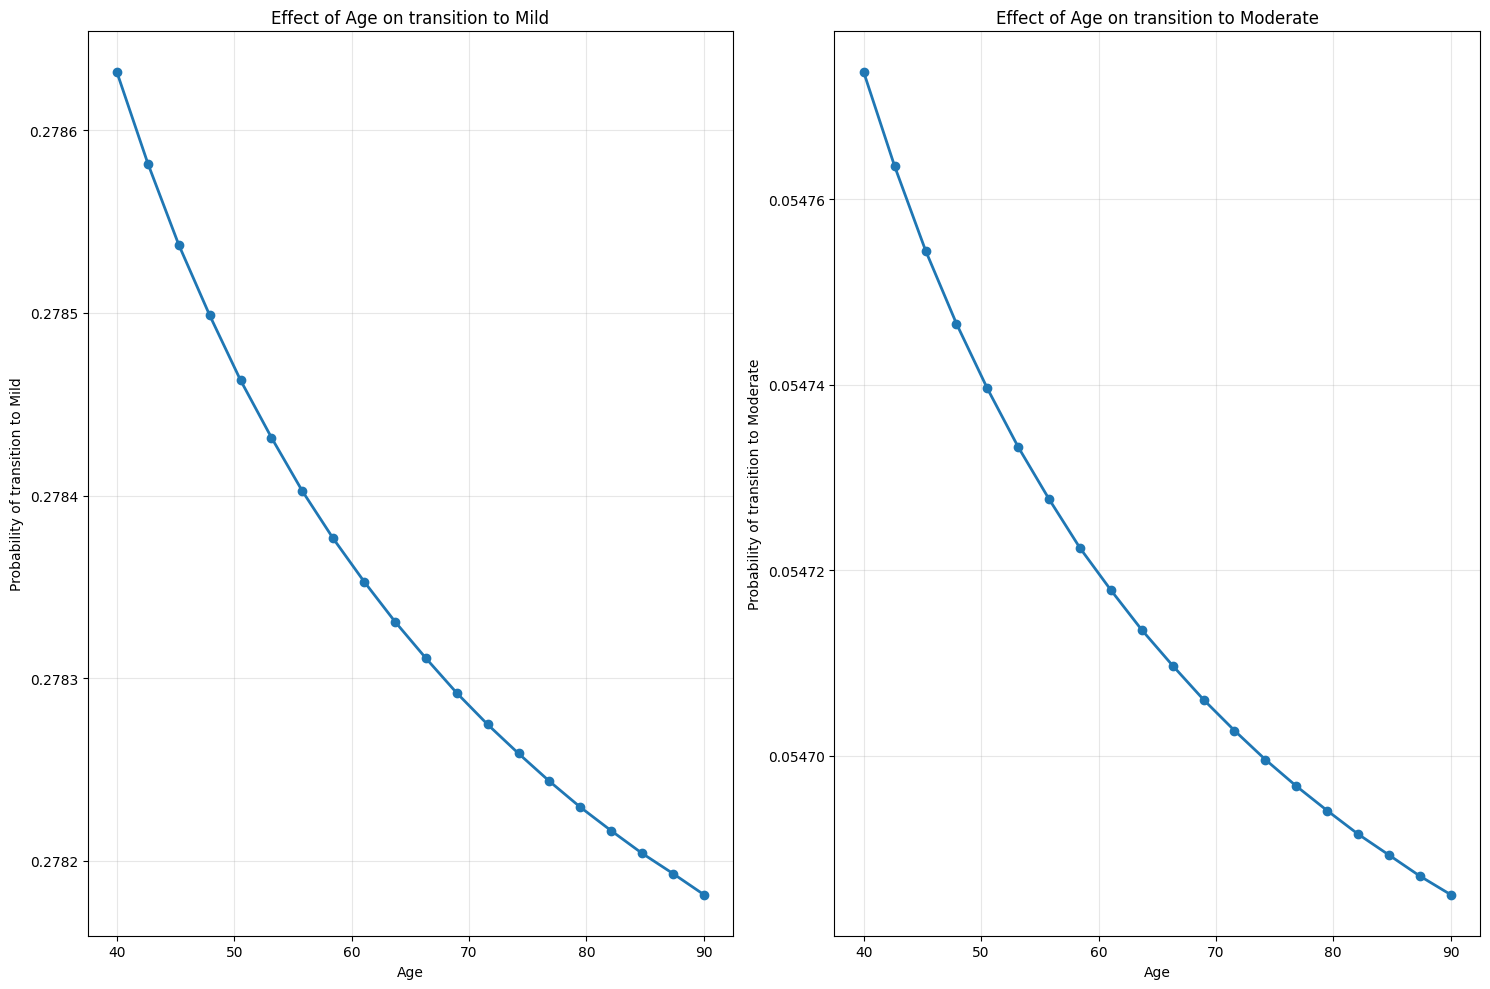

In [17]:
# Use the utility function to analyze the effect of biomarker on disease progression
# First, create a base profile with fixed values for other covariates
base_profile = torch.zeros(1, len(feature_names), dtype=torch.float32)
base_profile[0, feature_names.index('age')] = 65  # Average age
base_profile[0, feature_names.index('treatment')] = 0  # No treatment

# Analyze the effect of biomarker
# Note: No need to import analyze_covariate_effect again as it's already imported at the top
biomarker_effect = analyze_covariate_effect(
    model=model,
    base_profile=base_profile,
    covariate_idx=feature_names.index('biomarker'),
    covariate_values=np.linspace(0, 2, 20).tolist(),
    covariate_name='Biomarker',
    time_end=1.0,  # 1-year transition probabilities
    from_state=0,  # Starting from Healthy
    state_names=state_name_dict
)

plt.tight_layout()
plt.show()

# Also analyze the effect of age
age_effect = analyze_covariate_effect(
    model=model,
    base_profile=base_profile,
    covariate_idx=feature_names.index('age'),
    covariate_values=np.linspace(40, 90, 20).tolist(),
    covariate_name='Age',
    time_end=1.0,  # 1-year transition probabilities
    from_state=0,  # Starting from Healthy
    state_names=state_name_dict
)

plt.tight_layout()
plt.show()

Simulating disease progression trajectories...


/var/folders/7z/7gnwr49s6hl4pp9j5dcmgns80000gn/T/ipykernel_94091/2436785594.py:82: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 2)


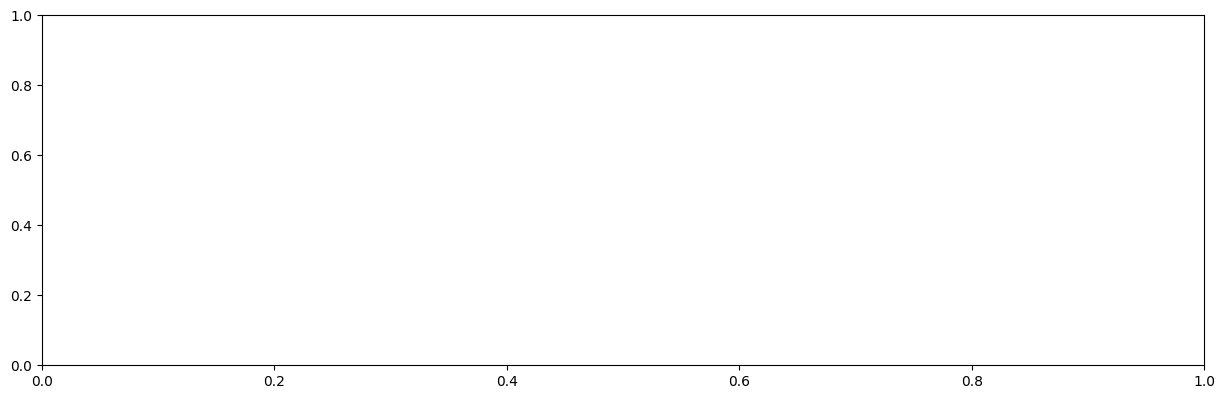

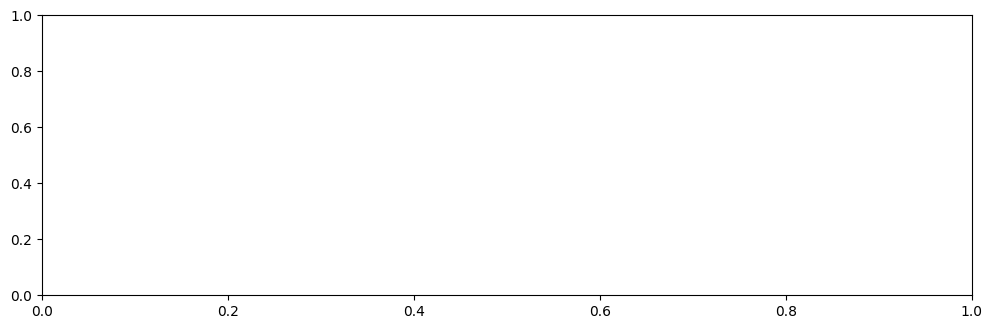

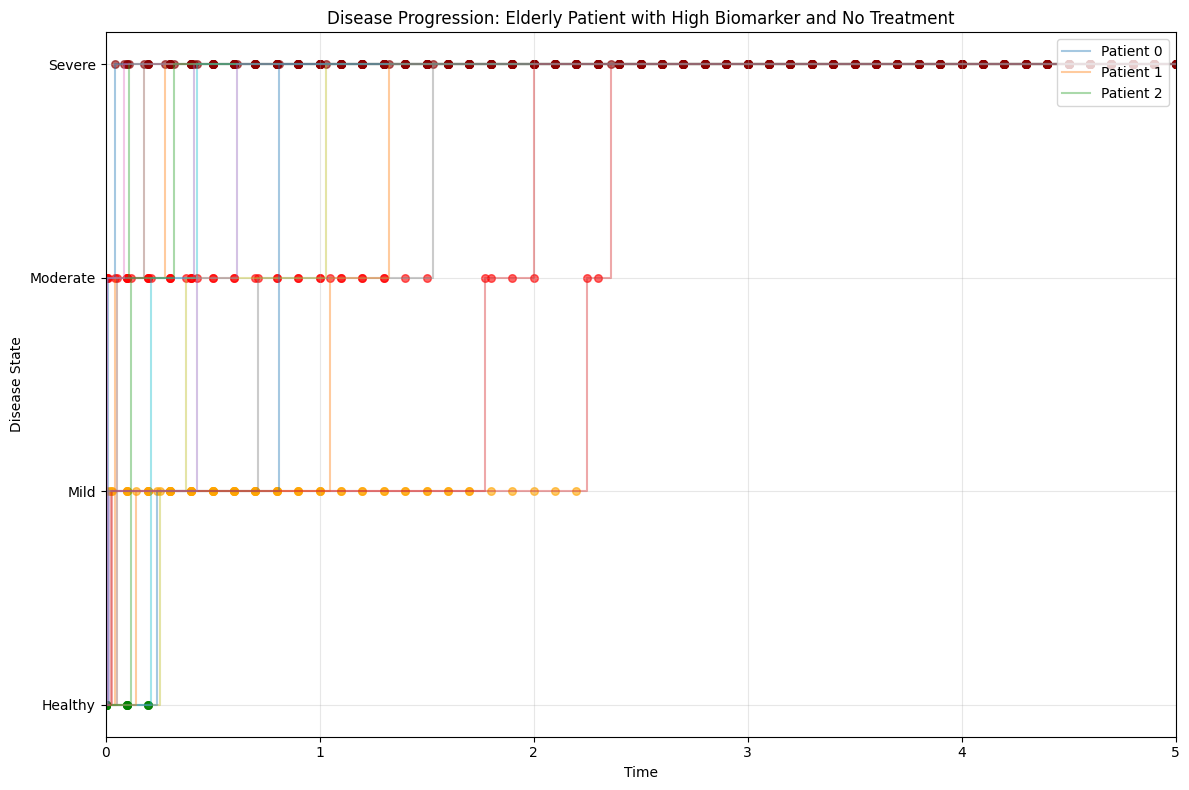

In [18]:
# Simulate patient trajectories

# Define two patient profiles for simulation
low_risk_patient = create_patient_profile(
    covariates={'age': 50, 'biomarker': 0.5, 'treatment': 1},  # Young, low biomarker, treated
    as_tensor=True
)

high_risk_patient = create_patient_profile(
    covariates={'age': 70, 'biomarker': 1.5, 'treatment': 0},  # Elderly, high biomarker, untreated
    as_tensor=True  
)

# Simulation parameters
max_time = 5.0  # Maximum time 
n_simulations = 50  # Number of simulations per patient

# Simulate trajectories for both patients
print("Simulating disease progression trajectories...")

# Low risk patient
low_risk_trajectories = simulate_continuous_patient_trajectory(
    model=model,
    x=low_risk_patient,
    start_state=0,  # Start in healthy state
    max_time=max_time,
    n_simulations=n_simulations,
    time_step=0.1,  # Time step for simulation grid
    seed=42
)

# High risk patient
high_risk_trajectories = simulate_continuous_patient_trajectory(
    model=model,
    x=high_risk_patient,
    start_state=0,  # Start in healthy state
    max_time=max_time,
    n_simulations=n_simulations,
    time_step=0.1,  # Time step for simulation grid
    seed=43
)

# Plot the trajectories
def plot_trajectories(trajectories, title, state_names=None, state_colors=None):
    """Plot multiple patient trajectories."""
    plt.figure(figsize=(12, 8))
    if state_names is None:
        state_names = ['Healthy', 'Mild', 'Moderate', 'Severe']
    if state_colors is None:
        state_colors = ['green', 'orange', 'red', 'darkred']
    
    # Plot each trajectory
    for i, traj in enumerate(trajectories[:15]):  # Show first 15 for clarity
        plt.step(traj['time'], traj['state'], where='post', alpha=0.4, 
                 label=f"Patient {i}" if i < 3 else None)
        
        # Add colored markers at state changes
        for state in range(len(state_names)):
            state_points = traj[traj['state'] == state]
            plt.scatter(state_points['time'], state_points['state'], 
                        color=state_colors[state], s=30, alpha=0.6)
    
    # Set y-axis ticks to state names
    plt.yticks(range(len(state_names)), state_names)
    plt.xlabel("Time")
    plt.ylabel("Disease State")
    plt.title(title)
    plt.grid(alpha=0.3)
    if len(trajectories) >= 3:
        plt.legend(loc='upper right')
    plt.xlim(0, max_time)
    
# Plot both sets of trajectories
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plot_trajectories(low_risk_trajectories, 
                  "Disease Progression: Young Patient with Low Biomarker and Treatment",
                  state_names=state_names, 
                  state_colors=state_colors)

plt.subplot(2, 1, 2)
plot_trajectories(high_risk_trajectories, 
                  "Disease Progression: Elderly Patient with High Biomarker and No Treatment",
                  state_names=state_names, 
                  state_colors=state_colors)

plt.tight_layout()
plt.show()

/Users/denizakdemir/.pyenv/versions/3.10.0/lib/python3.10/site-packages/torchdiffeq/_impl/misc.py:15: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 0.05}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
/var/folders/7z/7gnwr49s6hl4pp9j5dcmgns80000gn/T/ipykernel_94091/267340023.py:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)


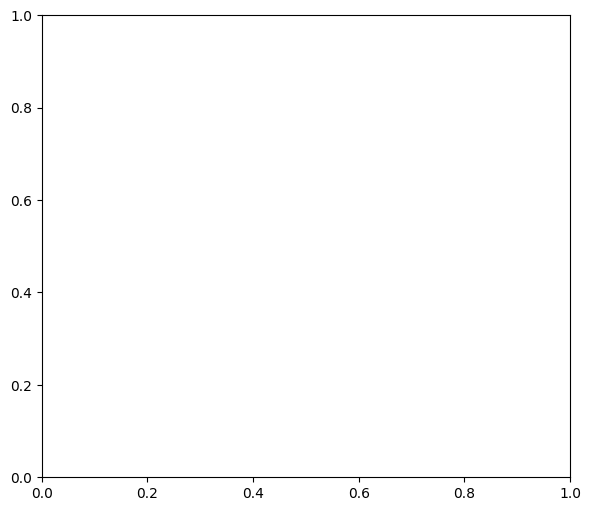

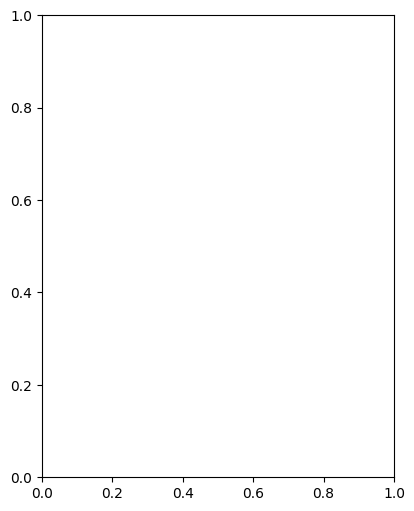

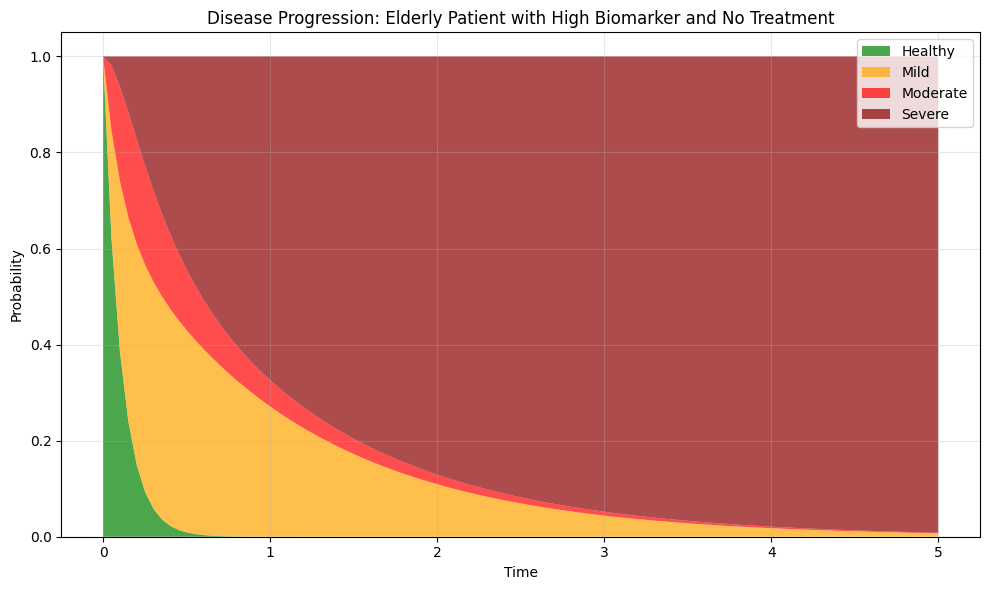

Time to 50% probability of reaching severe disease (state 3):
Low-risk patient: 0.61 years
High-risk patient: 0.61 years
Difference: 0.00 years


In [19]:
# Visualize state distribution over time for both patient profiles
plt.figure(figsize=(15, 6))

# Low-risk patient
plt.subplot(1, 2, 1)
visualize_state_distribution(
    model=model,
    patient_profile=low_risk_patient,
    from_state=0,
    max_time=max_time,
    num_points=100,
    state_names=state_names,
    state_colors=state_colors,
    title="Disease Progression: Young Patient with Low Biomarker and Treatment"
)

# High-risk patient
plt.subplot(1, 2, 2)
visualize_state_distribution(
    model=model,
    patient_profile=high_risk_patient,
    from_state=0,
    max_time=max_time,
    num_points=100,
    state_names=state_names,
    state_colors=state_colors,
    title="Disease Progression: Elderly Patient with High Biomarker and No Treatment"
)

plt.tight_layout()
plt.show()

# Calculate time to reach 50% probability of being in severe state
def time_to_probability(model, patient, from_state, target_state, max_time=5.0, num_points=100, target_prob=0.5):
    """Find the time at which probability of being in target_state reaches target_prob."""
    # Create time grid
    time_grid = np.linspace(0, max_time, num_points)
    
    # Get probabilities over time
    probs = np.zeros((num_points, model.num_states))
    for i, t in enumerate(time_grid):
        if i == 0:
            # At t=0, probability of being in the initial state is 1
            probs[i, from_state] = 1.0
        else:
            # Get probabilities from model
            t_tensor = torch.tensor([float(t)], dtype=torch.float32)
            p = model.predict_proba(patient, 
                                   time_start=torch.tensor([0.0], dtype=torch.float32), 
                                   time_end=t_tensor, 
                                   from_state=from_state).detach().numpy()
            probs[i] = p.squeeze()
            
    # Find first index where probability of target state exceeds target_prob
    for i, t in enumerate(time_grid):
        if probs[i, target_state] >= target_prob:
            return t
    return float('inf')  # Never reaches target probability

print("Time to 50% probability of reaching severe disease (state 3):")
target_state = 3  # severe disease
low_risk_time = time_to_probability(model, low_risk_patient, 0, target_state)
high_risk_time = time_to_probability(model, high_risk_patient, 0, target_state)

print(f"Low-risk patient: {low_risk_time:.2f} years")
print(f"High-risk patient: {high_risk_time:.2f} years")
print(f"Difference: {abs(high_risk_time - low_risk_time):.2f} years")

In [20]:
# Save the model for future use
try:
    model.save('disease_progression_model.pt')
    print("Model saved successfully!")
except Exception as e:
    print(f"Error saving model: {str(e)}")
    print("This feature may require an updated version of the multistate_nn package.")

Model saved successfully!
